In [156]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import re
import json
import pickle as pkl
from collections import Counter

from patsy import dmatrices
import statsmodels.api as sm

import statistics as s



## Loading data

In [157]:
file = 'test2.csv'
#conditions = ['tonic G4', 'tonic Bb4', 'tonic C4']
conditions = ['tonic G4']
df = pd.read_csv(file)

In [158]:
#getting list of participants
jspsych_ids = list(df['subject'].value_counts().index) 
print('Internal subject IDs:', jspsych_ids)

#matching jspsych ids to prolific ids
prolific_ids = []
for i in jspsych_ids:
    prolific_ids.append(json.loads(df[df['subject'] == i]['response'].iloc[0])['prolific_id'])

ids = pd.DataFrame(data = {'prolific_id': prolific_ids, 'jspsych_id': jspsych_ids})

Internal subject IDs: ['fpzo29', 'nf243h', 'a733u1', 'wo4onm']


In [159]:
#initializing valid participant list (participants included in analyses)
participant_ids = jspsych_ids
valid_participant_ids = participant_ids

In [160]:
"""UTILS"""


#calculating participant scores over correct columns
#takes the 'correct' column of a df as input
#used for exposure phase screening and scoring of fc tasks
def calculate_score(correct_column):
    if True in correct_column.value_counts():
        num_correct = correct_column.value_counts()[True]
        total_trials = len(correct_column)
        percent_correct = num_correct/total_trials*100
    else:
        percent_correct = 0
    return percent_correct

def plot_regression(x, y, xmin, xmax):
    regression_x = np.linspace(xmin, xmax, 30)
    coefs = np.polyfit(x, y, 1)
    f = np.poly1d(coefs)
    regression_y = f(regression_x)
    plt.plot(regression_x, regression_y, color = 'grey', alpha = 0.3)

#functions stolen from elsewhere

# calculate Cohen's d for independent samples
def cohend(d1, d2):
 n1, n2 = len(d1), len(d2)
 # calculate the variance of the samples
 s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
 # calculate the pooled standard deviation
 s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
 # calculate the means of the samples
 u1, u2 = np.mean(d1), np.mean(d2)
 # calculate the effect size
 return (u1 - u2) / s

#calculate 95% ci
def ci_95(y): #takes a list
    std = np.std(y)
    sem = std / np.sqrt(len(y))
    ci = 1.96 * sem
    return ci

## PART 1: Exposure phase 

Soundcheck

In [161]:
#how many participants answered default soundchecks correctly
soundcheck_df = df[df['task']=='soundcheck']

soundcheck_score = []

for i in participant_ids: 
    soundcheck_trials = soundcheck_df[soundcheck_df['subject'] == i]
    percent_correct = calculate_score(soundcheck_trials['correct'])
    soundcheck_score.append(percent_correct)

#making list of participants who failed soundchecks
soundcheck_failed = [x for x in participant_ids if soundcheck_score[participant_ids.index(x)]<50]

Attention check

In [162]:
#finding all exposure trials
exposure_df = df[df['subtask']=='attncheck']

#screening for participants who answered the exposure questions correctly
#creates a list of trials where the correct response rate < 80%
invalid_trials = []
attn_score = []

for i in participant_ids: 
    exposure_trials = exposure_df[exposure_df['subject'] == i]

    percent_correct = calculate_score(exposure_trials['correct'])
    print(i,percent_correct)
    
    attn_score.append(percent_correct)

fpzo29 100.0
nf243h 100.0
a733u1 0
wo4onm 100.0


[Text(0.5, 23.52222222222222, 'Test type'),
 Text(38.097222222222214, 0.5, 'Score')]

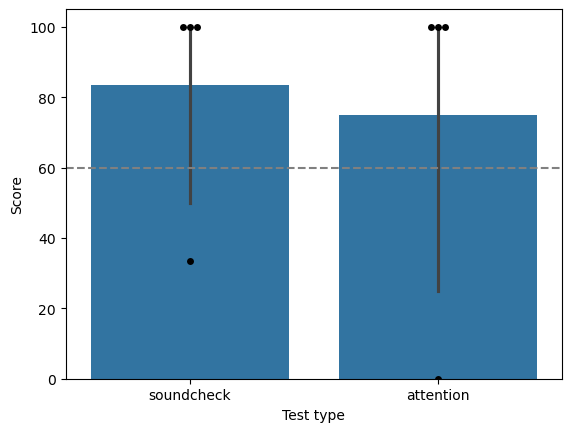

In [163]:
#soundcheck and attention scores
soundcheck_scores = pd.DataFrame([soundcheck_score]).transpose()
soundcheck_scores['type'] = 'soundcheck'

attn_scores = pd.DataFrame([attn_score]).transpose()
attn_scores['type'] = 'attention'
exposure_scores = pd.concat([soundcheck_scores, attn_scores])
exposure_scores.columns = ['score', 'type']

ax = sns.barplot(data = exposure_scores, x = 'type', y = 'score')
ax = sns.swarmplot(data = exposure_scores, x = 'type', y = 'score', color = 'black')
ax.axhline(60, color = 'grey', linestyle = '--')
ax.set(xlabel='Test type', ylabel='Score')

Attention check by difficulty

In [164]:
def define_diff(x):
    easy = re.search('easy', str(x))
    int = re.search('int', str(x))
    hard = re.search('hard', str(x))
    if easy: 
        return 'easy'
    elif int: 
        return 'int'
    elif hard:
        return 'hard'

exposure_df['attn_diff'] = exposure_df['stimulus'].map(define_diff)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/2667865876.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exposure_df['attn_diff'] = exposure_df['stimulus'].map(define_diff)


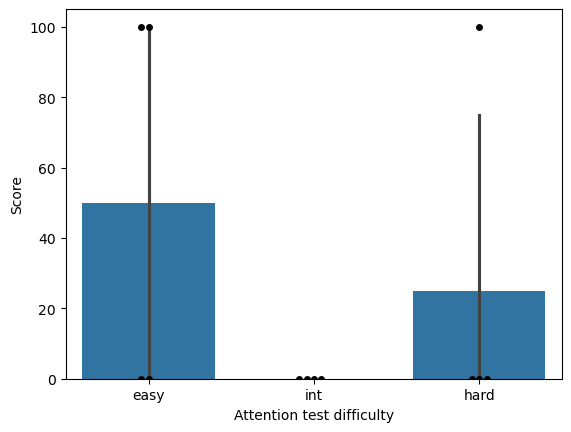

In [165]:
#putting data into df to plot with sns

attn_scores_easy = []
attn_scores_int = []
attn_scores_hard = []

for i in participant_ids: 
    easy_trials = exposure_df[(exposure_df['subject'] == i) & (exposure_df['attn_diff'] == 'easy')]
    int_trials = exposure_df[(exposure_df['subject'] == i) & (exposure_df['attn_diff'] == 'int')]
    hard_trials = exposure_df[(exposure_df['subject'] == i) & (exposure_df['attn_diff'] == 'hard')]


    easy_score = calculate_score(easy_trials['correct'])
    int_score = calculate_score(int_trials['correct'])
    hard_score = calculate_score(hard_trials['correct'])
    
    attn_scores_easy.append(easy_score)
    attn_scores_int.append(int_score)
    attn_scores_hard.append(hard_score)

df_easy = pd.DataFrame(data = {'participant': participant_ids, 'score': attn_scores_easy, 'difficulty': 'easy'})
df_int = pd.DataFrame(data = {'participant': participant_ids, 'score': attn_scores_int, 'difficulty': 'int'})
df_hard = pd.DataFrame(data = {'participant': participant_ids, 'score': attn_scores_hard, 'difficulty': 'hard'})

attn_scores_bydiff = pd.DataFrame()
attn_scores_bydiff = pd.concat([df_easy, df_int, df_hard])

ax = sns.barplot(data = attn_scores_bydiff, x = 'difficulty', y = 'score')
ax = sns.swarmplot(data = attn_scores_bydiff, x = 'difficulty', y = 'score', color = 'black')
#ax.axhline(60, color = 'grey', linestyle = '--')
ax.set(xlabel='Attention test difficulty', ylabel='Score')

plt.savefig('attn_test_scores.png', dpi = 300)

Grammar learning

In [166]:
df_learning = df[df['task'] == 'grammar_learning']

def map_grammaticality(x):
    if x[0:2] == 'gr':
        return 'grammatical'
    elif x[0:2] == 'ag':
        return 'agrammatical'

df_learning['grammaticality'] = df_learning['stimulus'].map(map_grammaticality)
df_learning['response'] = pd.to_numeric(df_learning['response'])
df_learning.head()

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1653981478.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_learning['grammaticality'] = df_learning['stimulus'].map(map_grammaticality)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1653981478.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_learning['response'] = pd.to_numeric(df_learning['response'])


,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,...,task,correct,subtask,slider_start,accent,high_IC,accent_chosen,high_IC_chosen,question_order,grammaticality
23,644,4,audio-slider-response,23,14284,0.0-19.0-0.0,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,grammar_learning,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,agrammatical
24,673,4,audio-slider-response,24,14980,0.0-19.0-0.1,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,grammar_learning,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,grammatical
25,325,4,audio-slider-response,25,15329,0.0-19.0-0.2,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,grammar_learning,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,agrammatical
26,279,4,audio-slider-response,26,15610,0.0-19.0-0.3,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,grammar_learning,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,grammatical
27,116,4,audio-slider-response,27,15756,0.0-19.0-0.4,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,grammar_learning,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,agrammatical


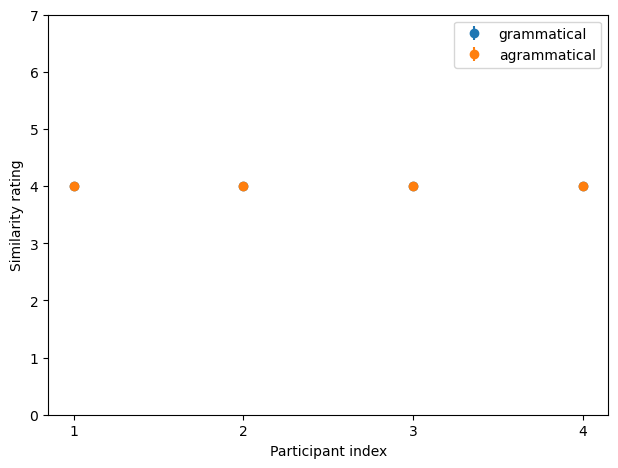

In [167]:
#grammatical learning difference 
fig = plt.figure(figsize = (7,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
#ax.set_xlim(0.75, 2.25)
ax.set_ylim(0,7)
ax.set_xticks(np.arange(1, len(valid_participant_ids)+1))
#ax.set_xticklabels(valid_participant_ids)
ax.set_ylabel('Similarity rating')
ax.set_xlabel('Participant index')


grammatical_means = []
agrammatical_means = []
grammatical_ci = []
agrammatical_ci = []
grammar_subj_stats = []

for i in valid_participant_ids:
    #grammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'].mean())
    subj_mean_grammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response']
    grammatical_means.append(subj_mean_grammatical.mean())
    #agrammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'].mean())
    subj_mean_agrammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response']
    agrammatical_means.append(subj_mean_agrammatical.mean())

    #testing whether participant had significantly different responses
    subj_stat = stats.ttest_rel(subj_mean_grammatical, subj_mean_agrammatical)
    grammar_subj_stats.append(subj_stat)
    #calculating CI95
    grammatical_ci.append(ci_95(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response']))
    agrammatical_ci.append(ci_95(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response']))

ax.errorbar(np.arange(1, len(grammatical_means)+1), grammatical_means, yerr = grammatical_ci,label = 'grammatical', fmt = 'o')
ax.errorbar(np.arange(1, len(agrammatical_means)+1), agrammatical_means, yerr = agrammatical_ci,label = 'agrammatical', fmt = 'o')
ax.legend()

plt.savefig('grammar_learning_error.png', dpi = 300)

In [168]:
#statistics about grammar learning
grammar_subj_stats

[TtestResult(statistic=nan, pvalue=nan, df=7),
 TtestResult(statistic=nan, pvalue=nan, df=7),
 TtestResult(statistic=nan, pvalue=nan, df=7),
 TtestResult(statistic=nan, pvalue=nan, df=7)]

TtestResult(statistic=nan, pvalue=nan, df=3)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1228005161.py:35: RuntimeWarning: invalid value encountered in scalar divide
  return (u1 - u2) / s


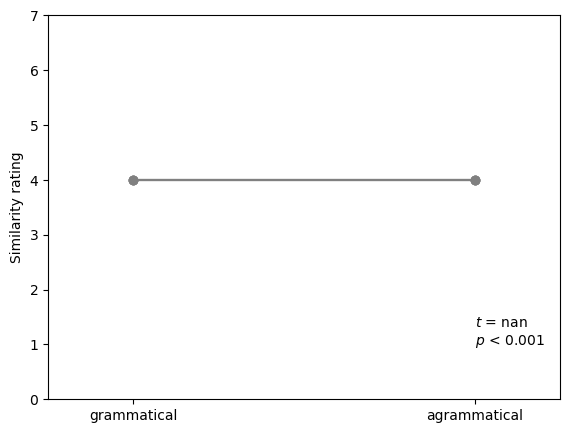

In [169]:
#grammar learning within subject
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
ax.set_xlim(0.75, 2.25)
ax.set_ylim(0,7)
ax.set_xticks([1,2])
ax.set_xticklabels(['grammatical', 'agrammatical'])
ax.set_ylabel('Similarity rating')
#paxlt.set_xlabel()

grammar_test_failed = []
grammar_cohend = []

for i in valid_participant_ids:
    grammatical_mean = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'].mean()
   # grammatical_ci = ci_95(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'])
    agrammatical_mean = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'].mean()
    ax.plot([1,2], [grammatical_mean, agrammatical_mean], 'o-', color = 'grey')
    #ax.errorbar([1,2], [grammatical_mean, agrammatical_mean], yerr= [grammatical_ci,1], fmt = 'o-')

    #eliminating participants who didn't learn the grammar
    if agrammatical_mean > grammatical_mean or agrammatical_mean == grammatical_mean:
        grammar_test_failed.append(i)
    
    cohend_current = cohend(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'], df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'])
    grammar_cohend.append(cohend_current)

#testing over all data points
grammar_res = stats.ttest_rel(grammatical_means, agrammatical_means)
print(grammar_res)
plt.text(2,1, '$t$ = '+str(round(grammar_res.statistic, 3))+'\n$p$ < 0.001 ')
plt.savefig('grammar_learning_within.png', dpi = 300)

### Filtering Participants

In [170]:
#extracting survey trials
survey = df[df['task']=='survey'] 

In [171]:
#birth year
age_labels =[int(x) for x in np.linspace(1920, 2020, 101).tolist()]
age_values = np.zeros(len(age_labels))

ages = []
for i in valid_participant_ids:
    #if int(json.loads(survey[survey['subject'] == i]['response'].iloc[1])['age']) == True:
    age = json.loads(survey[survey['subject'] == i]['response'].iloc[1])['age']
    #label_index = age_labels.index(age)
    #age_values[label_index] +=1
    ages.append(age)

#ages.remove('05th March 1982')
#ages.append('1982')
ages = [int(x) for x in ages]
"""fig = plt.figure()
fig.set_facecolor('white')

plt.title('Use of headphones')
"""
#plt.savefig('supp_headphone_use.png', dpi = 300)

print('Mean birth year: ', s.mean(ages))
print('Median birth year: ', s.median(ages))
print('Std birth year: ',s.stdev(ages))

ValueError: invalid literal for int() with base 10: 'vf'

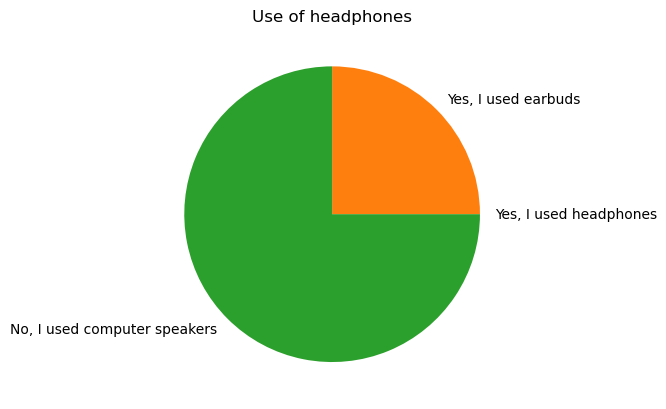

In [172]:
#headphone use
headphones_labels = ['Yes, I used headphones', 'Yes, I used earbuds', 'No, I used computer speakers']
headphones_values = np.zeros(len(headphones_labels))


for i in valid_participant_ids:
    headphone = json.loads(survey[survey['subject'] == i]['response'].iloc[0])['HeadphoneUse']
    label_index = headphones_labels.index(headphone)
    headphones_values[label_index] +=1

fig = plt.figure()
fig.set_facecolor('white')
plt.pie(headphones_values, labels = headphones_labels)
plt.title('Use of headphones')

plt.savefig('supp_headphone_use.png', dpi = 300)

Training years

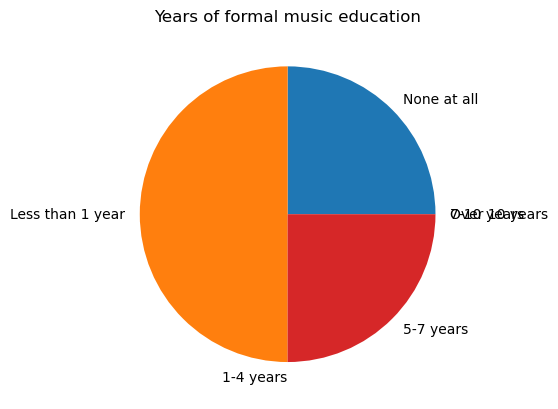

In [173]:
#musical background
training_labels = ['None at all', 'Less than 1 year', '1-4 years', '5-7 years', '7-10 years', 'Over 10 years']
training_values = np.zeros(len(training_labels))

#musicians = []
musicians_57 = []
musicians_710 = []
musicians_10 = []
nonmusicians = []

for i in valid_participant_ids:
    training = json.loads(survey[survey['subject'] == i]['response'].iloc[4])['TrainingYears'] #forgot to change the label of this question but should be TrainingYears
    label_index = training_labels.index(training)
    training_values[label_index] +=1

    #if training == '1-4 years':
    if training == '5-7 years':
        musicians_57.append(i)
    elif training == '7-10 years':
        musicians_710.append(i)
    elif training == 'Over 10 years':
        musicians_10.append(i)
    #if training == '1-4 years' or training == '5-7 years':
    #if training == '5-7 years' or training == 'Over 10 years' or training == '1-4 years':
        #musicians.append(i)

    elif training == 'None at all':
        nonmusicians.append(i)

fig = plt.figure()
fig.set_facecolor('white')
plt.pie(training_values, labels = training_labels)
plt.title('Years of formal music education')

plt.savefig('supp_music_training.png', dpi = 300)

Expertise

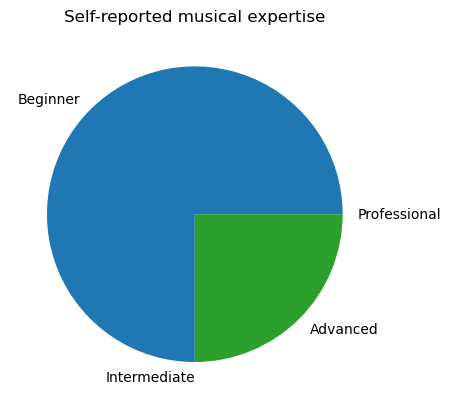

In [174]:
training_labels = ['Beginner', 'Intermediate', 'Advanced', 'Professional']
training_values = np.zeros(len(training_labels))

beginners = []
intermediate = []
advanced = []
professional = []

for i in valid_participant_ids:
    training = json.loads(survey[survey['subject'] == i]['response'].iloc[4])['Expertise'] #forgot to change the label of this question but should be TrainingYears
    label_index = training_labels.index(training)
    training_values[label_index] +=1

    if training == 'Beginner':
        beginners.append(i)
    elif training == 'Intermediate':
        intermediate.append(i)
    elif training == 'Advanced':
        advanced.append(i)
    elif training == 'Professional':
        professional.append(i)
    

fig = plt.figure()
fig.set_facecolor('white')
plt.pie(training_values, labels = training_labels)
plt.title('Self-reported musical expertise')

plt.savefig('supp_music_level.png', dpi = 300)

Start age

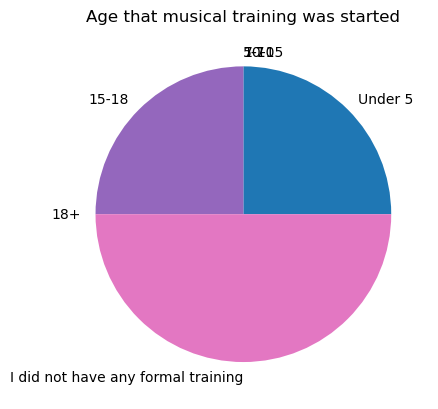

In [175]:
training_labels = ['Under 5', '5-7', '7-10', '10-15', '15-18', '18+', 'I did not have any formal training']
training_values = np.zeros(len(training_labels))

under7 = []
under10 = []
for i in valid_participant_ids:
    training = json.loads(survey[survey['subject'] == i]['response'].iloc[5])['TrainingStart'] #forgot to change the label of this question but should be TrainingYears
    label_index = training_labels.index(training)
    training_values[label_index] +=1

    if training == 'Under 5' or training == '5-7':
        under7.append(i)
        under10.append(i)
    elif training == '7-10':
        under10.append(i)

fig = plt.figure()
fig.set_facecolor('white')
plt.pie(training_values, labels = training_labels)
plt.title('Age that musical training was started')

plt.savefig('supp_start_age.png', dpi = 300)

Reaction times during forced choice

In [176]:
#defining forced choice
fc = df[df.loc[:,'task']=='forced_choice']


In [177]:
def pkl_to_list(filename):
    file = open(filename,'rb')
    loaded_list = pkl.load(file) #pilot 4.0 intermediate files\agrammatical_9.mid
    file.close()
    return loaded_list

"""
takes ONE melody and returns its expected length
"""
def calculate_duration(list): #assumes tempo of quarter note = 168
    quarternote = 60/168 
    melody = quarternote*len(list)
    duration = melody*2+quarternote*2 #because there are 2 melodies of the same length in each fc file, separated by a half rest
    return duration*1000 #want to have duration in ms to match rxn times



"""
takes a list of sequences and converts everything in the list to the expected durations
returns dataframe with file names and the list of durations
"""
def seq_to_dur_list(seq_list, filename):
    
    duration_list = []
    filenames = []
    file_index = 1

    for item in seq_list:
        duration = calculate_duration(item)
        duration_list.append(duration)
        filenames.append(str(filename)+'_'+str(file_index)+'.mp3')
        
        file_index +=1
    df = pd.DataFrame(data = {'filename': filenames, 'duration': duration_list})
    return df

"""
takes a list of sequences and returns a dataframe with file names and sequences
"""
def seq_to_df(seq_list, filename):

    filenames = []
    file_index = 1

    for item in seq_list:
        filenames.append(str(filename)+'_'+str(file_index)+'.mp3')
        
        file_index +=1
    df = pd.DataFrame(data = {'filename': filenames, 'sequence': seq_list})
    return df

In [178]:
"""
takes the pkl lists in an experiment folder and returns their expected durations
folder should be a string of the folder name
tonic should be 'tonic G4, tonic C4, etc' 
"""
def pkl_to_dur(folder, tonic):

    fc_IC_default_short_5 = pkl_to_list(folder+'/fc_IC_default_short_5.pkl')
    fc_IC_accent_short_5 = pkl_to_list(folder+'/fc_IC_accent_short_5.pkl')
    fc_IC_default_short_3 = pkl_to_list(folder+'/fc_IC_default_short_3.pkl')
    fc_IC_accent_short_3 = pkl_to_list(folder+'/fc_IC_accent_short_3.pkl')

    fc_accents_short_54 = pkl_to_list(folder+'/fc_accents_short_54.pkl')
    fc_accents_short_56 = pkl_to_list(folder+'/fc_accents_short_56.pkl')
    fc_accents_short_34 = pkl_to_list(folder+'/fc_accents_short_34.pkl')
    fc_accents_short_32 = pkl_to_list(folder+'/fc_accents_short_32.pkl')

    dur_df = pd.DataFrame(columns=['filename', 'duration', 'condition'])

    df_1 = seq_to_dur_list(fc_accents_short_54, 'fc_accents_54')
    df_2 = seq_to_dur_list(fc_accents_short_56, 'fc_accents_56')
    df_3 = seq_to_dur_list(fc_accents_short_32, 'fc_accents_32')
    df_4 = seq_to_dur_list(fc_accents_short_34, 'fc_accents_34')


    df_5 = seq_to_dur_list(fc_IC_default_short_5, 'fc_IC_default_5')
    df_6 = seq_to_dur_list(fc_IC_accent_short_5, 'fc_IC_accent_5')
    df_7 = seq_to_dur_list(fc_IC_default_short_3, 'fc_IC_default_3')
    df_8 = seq_to_dur_list(fc_IC_accent_short_3, 'fc_IC_accent_3')


    dur_df= pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], ignore_index= True)
    dur_df['condition'] = tonic

    return dur_df


In [179]:
"""dur_df_G = pkl_to_dur('pkl files pilot 5', 'tonic G4')
dur_df_Bb = pkl_to_dur('pkl files pilot 5_1', 'tonic Bb4')
dur_df_C = pkl_to_dur('pkl files pilot 5_2', 'tonic C4')"""

dur_df_G = pkl_to_dur('../intermediate_files/5', 'tonic G4')
dur_df_all = pd.concat([dur_df_G])

In [180]:
dur_df_all

,filename,duration,condition
0,fc_accents_54_1.mp3,5714.285714,tonic G4
1,fc_accents_54_2.mp3,5714.285714,tonic G4
2,fc_accents_54_3.mp3,6428.571429,tonic G4
3,fc_accents_54_4.mp3,5714.285714,tonic G4
4,fc_accents_56_1.mp3,5000.000000,tonic G4
5,fc_accents_56_2.mp3,5714.285714,tonic G4
6,fc_accents_56_3.mp3,5714.285714,tonic G4
7,fc_accents_56_4.mp3,5714.285714,tonic G4
8,fc_accents_32_1.mp3,5714.285714,tonic G4
9,fc_accents_32_2.mp3,6428.571429,tonic G4


In [212]:
fc['condition'] = 'tonic G4'

def add_duration(row):
    for i in conditions: 
        if row['condition'] == i:
            if row['stimulus'] in dur_df_all['filename'].values:
                return float(dur_df_all[(dur_df_all['filename'] == row['stimulus']) & (dur_df_all['condition'] == row['condition'])]['duration'].iloc[0])


fc['expected_duration'] = fc.apply(add_duration, axis=1)
fc['normalized_rxntime'] = fc['rt']-fc['expected_duration']

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1405685294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['condition'] = 'tonic G4'
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1405685294.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['expected_duration'] = fc.apply(add_duration, axis=1)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/1405685294.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [213]:
fc['expected_duration']

44     5714.285714
45     5714.285714
46     5000.000000
47     5714.285714
48     6428.571429
          ...     
326    6428.571429
327    6428.571429
328    6428.571429
329    6428.571429
330    6428.571429
Name: expected_duration, Length: 128, dtype: float64

In [215]:


num_participants = len(valid_participant_ids)
num_rows = (num_participants + 1) // 2  # Calculate the number of rows needed
num_cols = 2  # Number of columns

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, num_rows), sharey = True)

for i, participant_id in enumerate(valid_participant_ids):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    #ax.hist(fc[fc['subject'] == participant_id]['normalized_rxntime'], bins=np.linspace(-10000, 30000, 30))
    ax.hist(fc[fc['subject'] == participant_id]['normalized_rxntime'], bins=60, range = (-10000, 30000))
    ax.set_xlim(-10000, 30000)
    ax.vlines(0, 0, 10, linestyles='--', color='black')
    ax.set_title(participant_id, fontdict={'fontsize': 10})

fig.text(0.001, 0.5, 'Frequency in response times', va='center', rotation='vertical', fontdict={'fontsize': 12})
fig.text(0.5, 0.001, 'Response time relative to melody end (ms)', ha='center', fontdict={'fontsize': 12})

fig.delaxes(axs[-1,-1])
plt.tight_layout()

#plt.savefig('./figures for paper/supp_rxntime.png', dpi = 300)


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

In [183]:
#eliminating participants who responded >3s before end of the melody 
#this is now earlier in the code

unthinking_participants = []
for i in valid_participant_ids:
    fc_current = fc[fc['subject'] == i]
    #if fc_current['normalized_rxntime'].min() < -2000:
    #if fc_current['normalized_rxntime'].min() < -2000 and fc_current['normalized_rxntime'].max() > 5000:
    if fc_current['normalized_rxntime'].std() > 2000:
        unthinking_participants.append(i)



#fc_rxn_filtered = fc[(fc['normalized_rxntime'] > 0) & (fc['normalized_rxntime'] < 70000) ]
print(unthinking_participants)


[]


Rejecting participants

In [184]:
print('Soundcheck failed:', len(soundcheck_failed), 'participants', soundcheck_failed)
print('Answered too fast:', len(unthinking_participants), 'participants', unthinking_participants)
print('Didn\'t learn grammar', len(grammar_test_failed), 'participants', grammar_test_failed)

failed_participants = soundcheck_failed + unthinking_participants + grammar_test_failed #no longer looking at attention test


failed_participants = list(dict.fromkeys(failed_participants))

print('\n Failed participants: ', len(failed_participants))



Soundcheck failed: 1 participants ['wo4onm']
Answered too fast: 0 participants []
Didn't learn grammar 4 participants ['fpzo29', 'nf243h', 'a733u1', 'wo4onm']

 Failed participants:  4


CHOOSING PARTICIPANTS

The valid_participant_ids list can be modified to include only the people we want in the analysis. Participants are filtered by grammar learning and demographics later in this notebook, so everything should be run once before adjusting this parameter.

In [220]:
#choosing which dataset to analyze for the rest of the analysis 

"""
inclusion for participants based on specific traits
"""
valid_participant_ids = participant_ids
#valid_participant_ids = musicians_57+musicians_710+musicians_10

#valid_participant_ids = [x for x in valid_participant_ids if x not in failed_participants+musicians_10+musicians_57+musicians_710]

"""
RUN FIRST:
"""
valid_participant_ids = [x for x in valid_participant_ids if x not in failed_participants] 


print('Participants included:', valid_participant_ids)
print('Number of participants:', len(valid_participant_ids))

Participants included: ['fpzo29', 'nf243h', 'a733u1', 'wo4onm']
Number of participants: 4


Melody liking

In [221]:
df_liking = df[df['subtask'] == 'exp_liking']

liking_x = []
liking_y = []

for subject in valid_participant_ids:
   # df_liking_current = df_liking[df_liking['subject'] == subject]
    df_liking_current = [int(x) for x in df_liking[df_liking['subject'] == subject]['response'].tolist()]
    liking_y.append(df_liking_current)
    df_liking_index = [int(x) for x in df_liking[df_liking['subject'] == subject]['trial_index'].tolist()]
    liking_x.append(df_liking_index)
   

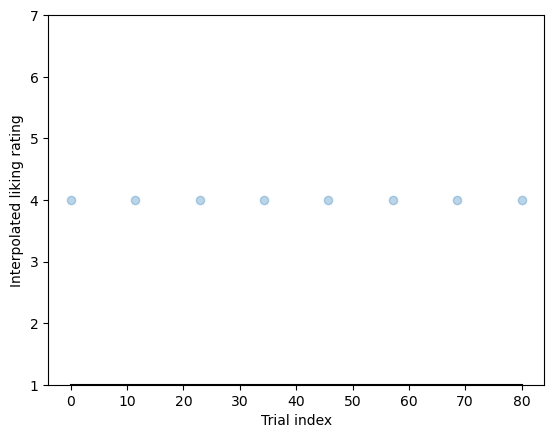

In [222]:
#interpolation for melody liking
interp_x = np.linspace(0, 80, 8)
interp_y_arr = np.zeros((len(liking_x), len(interp_x)))

plt.figure()
plt.xlabel("Trial index")
plt.ylabel("Interpolated liking rating")
plt.ylim((1,7))

for i in range(len(liking_x)):
    if len(liking_x[i]) != 0:
        interp_y = np.interp(interp_x, liking_x[i], liking_y[i])
        interp_y_arr[i] = interp_y

        plt.scatter(interp_x, interp_y, alpha = 0.3)

mean_interp_y = np.mean(interp_y_arr, axis=0)
plt.plot(interp_x, mean_interp_y, color='black')
plt.savefig('supp_likingratings.png', dpi = 300)


Redefining musicians vs nonmusicians

In [223]:
musicians = [x for x in musicians_57+musicians_710+musicians_10 if x not in failed_participants]
#musicians = [x for x in musicians_710+musicians_10 if x not in failed_participants]

nonmusicians = [x for x in participant_ids if x not in musicians and x not in failed_participants]

Grammar learning plots (after filtering for participants)

In [224]:
ci_95(df_learning[(df_learning['subject'].isin(musicians)) & (df_learning['grammaticality']=='grammatical')]['response'])

nan

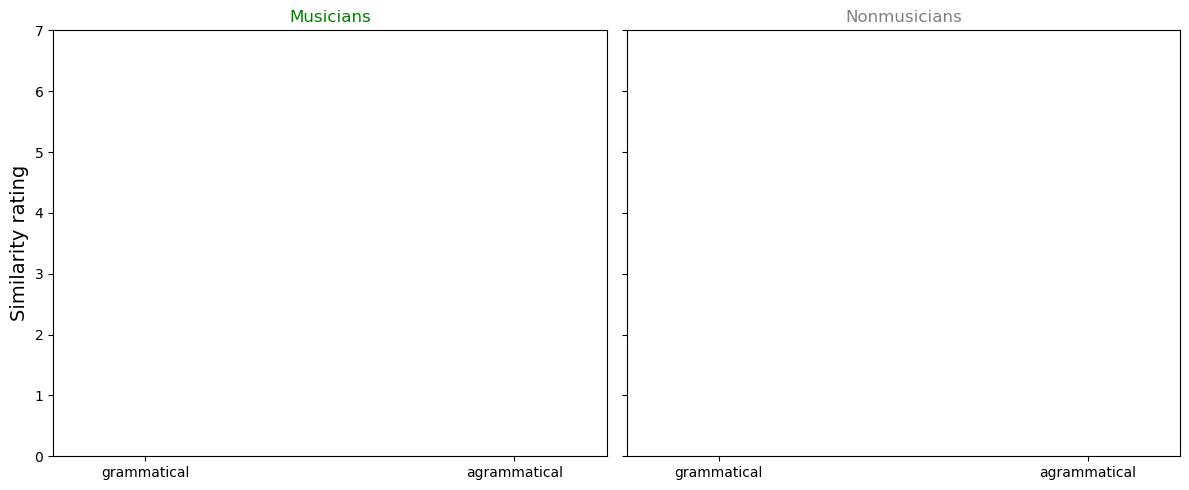

In [225]:
def plot_ws_grammar(people, shade, ax):

    ax.set_xlim(0.75, 2.25)
    ax.set_ylim(0,7)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['grammatical', 'agrammatical'])

    for i in people:
        grammatical_mean = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'].mean()
        agrammatical_mean = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'].mean()
        
        jitter = np.random.normal(-0.05,0.05, 2)
        ax.plot([1,2]+jitter, [grammatical_mean, agrammatical_mean], 'o-', color = shade, alpha = 0.2, markersize = 2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5), sharey = True)

mus_mean_g = df_learning[(df_learning['subject'].isin(musicians)) & (df_learning['grammaticality']=='grammatical')]['response'].mean()
mus_ci_g = ci_95(df_learning[(df_learning['subject'].isin(musicians)) & (df_learning['grammaticality']=='grammatical')]['response'])

mus_mean_ag = df_learning[(df_learning['subject'].isin(musicians)) & (df_learning['grammaticality']=='agrammatical')]['response'].mean()
mus_ci_ag = ci_95(df_learning[(df_learning['subject'].isin(musicians)) & (df_learning['grammaticality']=='agrammatical')]['response'])

nmus_mean_g = df_learning[(df_learning['subject'].isin(nonmusicians)) & (df_learning['grammaticality']=='grammatical')]['response'].mean()
nmus_ci_g = ci_95(df_learning[(df_learning['subject'].isin(nonmusicians)) & (df_learning['grammaticality']=='grammatical')]['response'])

nmus_mean_ag = df_learning[(df_learning['subject'].isin(nonmusicians)) & (df_learning['grammaticality']=='agrammatical')]['response'].mean()
nmus_ci_ag = ci_95(df_learning[(df_learning['subject'].isin(nonmusicians)) & (df_learning['grammaticality']=='agrammatical')]['response'])

plot_ws_grammar(musicians, 'green', ax1)
ax1.set_title('Musicians', color = 'green')
ax1.errorbar([1,2], [mus_mean_g, mus_mean_ag], [mus_ci_g, mus_ci_ag], fmt = 'o-', color = 'green')
ax1.set_ylabel('Similarity rating', fontsize = 14)

plot_ws_grammar(nonmusicians, 'grey', ax2)
ax2.set_title('Nonmusicians', color = 'grey')
ax2.errorbar([1,2], [nmus_mean_g, nmus_mean_ag], [nmus_ci_g, nmus_ci_ag], fmt = 'o-', color = 'grey')

plt.tight_layout()

#plt.savefig('./figures for paper/ws_grammar.png', dpi = 500)

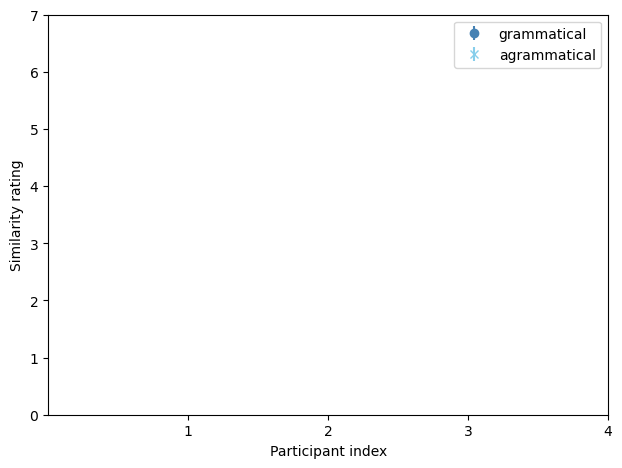

In [226]:
#grammatical learning difference 
fig = plt.figure(figsize = (7,5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 
#ax.set_xlim(0.75, 2.25)
ax.set_ylim(0,7)
ax.set_xticks(np.arange(1, len(valid_participant_ids)+1))
#ax.set_xticklabels(valid_participant_ids)
ax.set_ylabel('Similarity rating')
ax.set_xlabel('Participant index')


grammatical_means = []
agrammatical_means = []
grammatical_ci = []
agrammatical_ci = []
grammar_subj_stats = []

for i in musicians+nonmusicians:
    #grammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'].mean())
    subj_mean_grammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response']
    grammatical_means.append(subj_mean_grammatical.mean())
    #agrammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'].mean())
    subj_mean_agrammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response']
    agrammatical_means.append(subj_mean_agrammatical.mean())

    #testing whether participant had significantly different responses
    subj_stat = stats.ttest_rel(subj_mean_grammatical, subj_mean_agrammatical)
    grammar_subj_stats.append(subj_stat)

    #calculating CI95
    grammatical_ci.append(ci_95(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response']))
    agrammatical_ci.append(ci_95(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response']))

ax.errorbar(np.arange(1, len(grammatical_means)+1), grammatical_means, yerr = grammatical_ci,label = 'grammatical', fmt = 'o', color = 'steelblue')
ax.errorbar(np.arange(1, len(agrammatical_means)+1), agrammatical_means, yerr = agrammatical_ci,label = 'agrammatical', fmt = 'x', color = 'skyblue')
ax.legend()

#plt.savefig('./figures for paper/grammar_learning_error.png', dpi = 500)

In [227]:
#stats on the confidence intervals in musicians vs nonmusicians
error_mus_g = grammatical_ci[:9]
error_nmus_g = grammatical_ci[9:]

error_mus_ag = agrammatical_ci[:9]
error_nmus_ag = agrammatical_ci[9:]

stats.ttest_ind(error_mus_ag, error_nmus_ag)

TtestResult(statistic=nan, pvalue=nan, df=nan)

In [228]:
#cohens d
for i in musicians:
    #grammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response'].mean())
    subj_mean_grammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'grammatical')]['response']
   # grammatical_means.append(subj_mean_grammatical.mean())

    #agrammatical_means.append(df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response'].mean())
    subj_mean_agrammatical = df_learning[(df_learning['subject']==i) & (df_learning['grammaticality'] == 'agrammatical')]['response']
 #   agrammatical_means.append(subj_mean_agrammatical.mean())


## PART 2: Forced choice analysis

In [229]:
#extracting fc data from big dataframe
fc = df[df.loc[:,'task']=='forced_choice']

#adding column for test type
def truncate_stimulus_type(x):
    if x[3:5] == 'ac':
        return 'accent'
    elif x[3:5] == 'IC' and x[6] == 'd':
        return 'IC_default'
    elif x[3:5] == 'IC' and x[6] == 'a':
        return 'IC_accent'
fc['test_type'] = fc['stimulus'].map(truncate_stimulus_type)

#adding column for IC
def truncate_stimulus_IC(x):
    if x[-8:-6] == '54' or x[-8:-6] == '34':
        return 'low'
    elif x[-8:-6] == '32' or x[-8:-6] == '56':
        return 'high'
    else:
        return 'NA'
fc['IC'] = fc['stimulus'].map(truncate_stimulus_IC)

#adding column for context note
def truncate_context(x):
    if x[-8:-7] == '5' or x[-8:-7] == '3':
        return x[-8:-7]
    else:
        return x[-7:-6]
fc['context'] = fc['stimulus'].map(truncate_context)

fc.head()


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/2433560914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['test_type'] = fc['stimulus'].map(truncate_stimulus_type)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/2433560914.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['IC'] = fc['stimulus'].map(truncate_stimulus_IC)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_27890/2433560914.py:30: SettingWithCopyWarning: 
A value is trying to be set on a 

,rt,response,trial_type,trial_index,time_elapsed,internal_node_id,run_id,condition,recorded_at,source_code_version,...,subtask,slider_start,accent,high_IC,accent_chosen,high_IC_chosen,question_order,test_type,IC,context
44,1776,f,audio-keyboard-response,44,23309,0.0-25.0-0.0,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,NaN,NaN,NaN,f,False,True,NaN,IC_accent,NA,3
45,58,j,audio-keyboard-response,45,23398,0.0-25.0-0.1,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,NaN,NaN,j,NaN,True,False,NaN,accent,high,5
46,99,f,audio-keyboard-response,46,23514,0.0-25.0-0.2,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,NaN,NaN,NaN,j,False,False,NaN,IC_accent,NA,5
47,70,j,audio-keyboard-response,47,23601,0.0-25.0-0.3,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,NaN,NaN,NaN,j,False,True,NaN,IC_default,NA,5
48,64,f,audio-keyboard-response,48,23689,0.0-25.0-0.4,4,tonic Bb4,2024-04-29 16:00:06,70dd8527a7d03d02011aab09188cbbde,...,NaN,NaN,NaN,f,False,True,NaN,IC_default,NA,3


### Score between accents

(choice is between accented and unaccented versions of the same melody)

In [230]:
fc_accents = fc[fc['test_type']=='accent']


high_IC_accent_scores = []
low_IC_accent_scores = []

#screening for participants who answered the exposure questions correctly
for i in valid_participant_ids: 
    included_trials = fc_accents[fc_accents['subject'] == i]

    high_IC_trials = included_trials[included_trials['IC'] == 'high']
    low_IC_trials = included_trials[included_trials['IC'] == 'low']

    score_high_IC = calculate_score(high_IC_trials['accent_chosen'])
    score_low_IC = calculate_score(low_IC_trials['accent_chosen'])

    high_IC_accent_scores.append(score_high_IC)
    low_IC_accent_scores.append(score_low_IC)
    
        
fc_results_accent_high = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_accent_scores, 'IC': 'high'})
fc_results_accent_low = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': low_IC_accent_scores, 'IC': 'low'})
fc_accent_results = pd.concat([fc_results_accent_high,fc_results_accent_low])

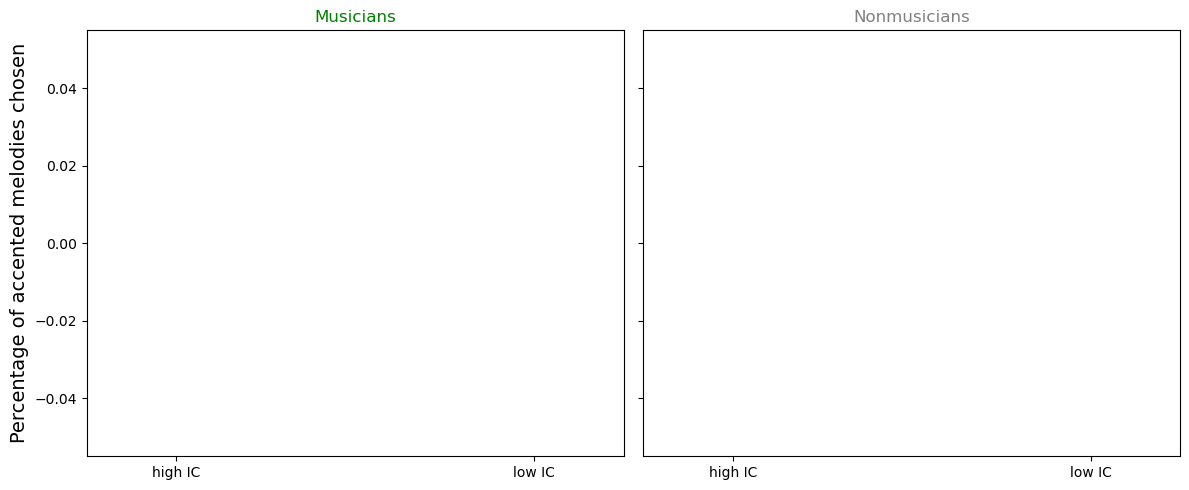

In [232]:
#same plot as above but with direct comparison between musicians and nonmusicians
def plot_ws_accent(people, shade, ax):
    ax.set_xlim(0.75, 2.25)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['high IC', 'low IC'])

    accent_chosen_low = []
    accent_chosen_high = []

    for i in people:
        high_result = fc_accent_results[(fc_accent_results['valid_participant_ids']==i) & (fc_accent_results['IC']=='high')]['score']
        low_result = fc_accent_results[(fc_accent_results['valid_participant_ids']==i) & (fc_accent_results['IC']=='low')]['score']

        accent_chosen_low.append((low_result))
        accent_chosen_high.append((high_result))
        jitter = np.random.normal(-0.04,0.04, 2)
        ax.plot([1,2]+jitter, [high_result, low_result], 'o-', color = shade, alpha = 0.2, markersize = 3)

#calculating group statistics
mus_mean_hi = fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(musicians)) & (fc_accent_results['IC']=='high')]['score'].mean()
mus_ci_hi = ci_95(fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(musicians)) & (fc_accent_results['IC']=='high')]['score'])

mus_mean_lo = fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(musicians)) & (fc_accent_results['IC']=='low')]['score'].mean()
mus_ci_lo = ci_95(fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(musicians)) & (fc_accent_results['IC']=='low')]['score'])

nnmus_mean_hi = fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(nonmusicians)) & (fc_accent_results['IC']=='high')]['score'].mean()
nmus_ci_hi = ci_95(fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(nonmusicians)) & (fc_accent_results['IC']=='high')]['score'])

nmus_mean_lo = fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(nonmusicians)) & (fc_accent_results['IC']=='low')]['score'].mean()
nmus_ci_lo = ci_95(fc_accent_results[(fc_accent_results['valid_participant_ids'].isin(nonmusicians)) & (fc_accent_results['IC']=='low')]['score'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey = True)

plot_ws_accent(musicians, 'green', ax1)
ax1.errorbar([1,2], [mus_mean_hi, mus_mean_lo], yerr = [mus_ci_hi, mus_ci_lo], fmt = 'o-', color = 'green')
ax1.set_title('Musicians', color = 'green')
ax1.set_ylabel('Percentage of accented melodies chosen', fontsize = 14)

plot_ws_accent(nonmusicians, 'grey', ax2)
ax2.set_title('Nonmusicians', color = 'grey')
ax2.errorbar([1,2], [nnmus_mean_hi, nmus_mean_lo], yerr = [nmus_ci_hi, nmus_ci_lo], fmt = 'o-', color = 'grey')

plt.tight_layout()

#plt.savefig('./figures for paper/ws_accent.png', dpi = 500)

### Score between IC 

(choice is between target note that is low or high IC)

In [ ]:
#IC forced choice where the target note is accented
fc_ICs = fc[fc['test_type']=='IC_accent' ]


high_IC_chosen_accent = []

#screening for participants who answered the exposure questions correctly
for i in valid_participant_ids: 
    included_trials = fc_ICs[fc_ICs['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen_accent.append(score_IC)
        
fc_IC_results_accent = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen_accent})
"""
ax = sns.barplot(data = fc_IC_results_accent, x  = 'valid_participant_ids' , y = 'score', ci = 'sd', palette= ['grey'])
ax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Target note accented')"""

"\nax = sns.barplot(data = fc_IC_results_accent, x  = 'valid_participant_ids' , y = 'score', ci = 'sd', palette= ['grey'])\nax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Target note accented')"

In [ ]:
#IC forced choice where the target note is NOT accented
fc_ICs = fc[fc['test_type']=='IC_default' ]


high_IC_chosen_default = []

#screening for participants who answered the exposure questions correctly
for i in valid_participant_ids: 
    included_trials = fc_ICs[fc_ICs['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen_default.append(score_IC)
        
fc_IC_default_results = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen_default})
fc_IC_default_results

"""ax = sns.barplot(data = fc_IC_default_results, x  = 'valid_participant_ids' , y = 'score', ci = 'sd', palette= ['grey'])
ax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Target note not accented')"""

"ax = sns.barplot(data = fc_IC_default_results, x  = 'valid_participant_ids' , y = 'score', ci = 'sd', palette= ['grey'])\nax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Target note not accented')"

In [ ]:
fc_IC_results_accent['type'] = 'accent'
fc_IC_default_results['type'] = 'default'
fc_IC_results = pd.concat([fc_IC_results_accent, fc_IC_default_results])

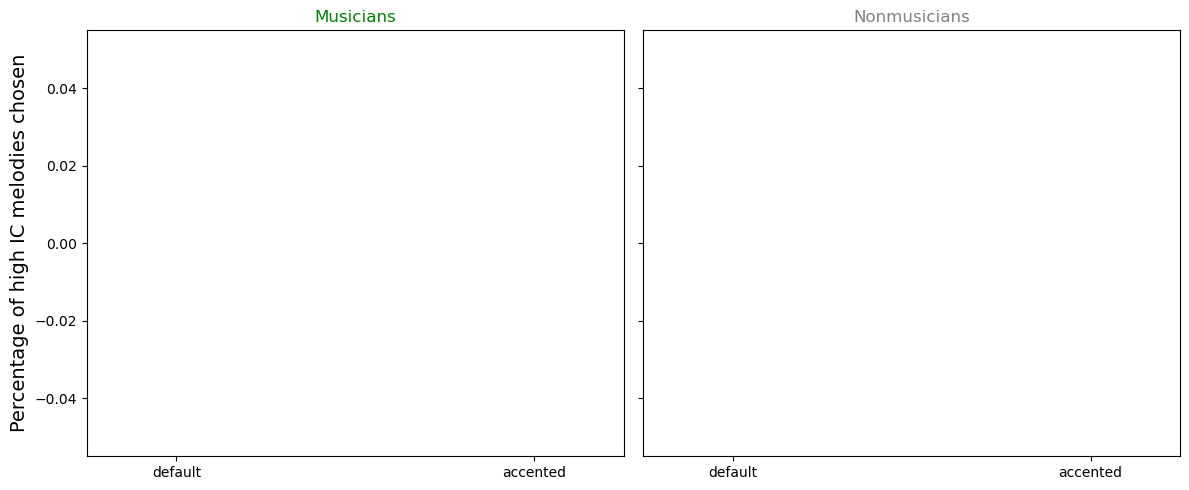

In [ ]:
#same as plot above but with multiple groups compared in subplots
def plot_ws_IC(people, shade, ax):
    ax.set_xlim(0.75, 2.25)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['default', 'accented'])
   # ax.set_ylabel('High IC melody chosen')

    fc_IC_accent = []
    fc_IC_default = []

    for i in people:
        accent_result = fc_IC_results[(fc_IC_results['valid_participant_ids'] == i) & (fc_IC_results['type'] == 'accent')]['score']
        default_result = fc_IC_results[(fc_IC_results['valid_participant_ids'] == i) & (fc_IC_results['type'] == 'default')]['score']

        fc_IC_accent.append(accent_result)
        fc_IC_default.append(default_result)

        jitter = np.random.uniform(-0.11, 0.11, 2)
        ax.plot([1,2]+ jitter, [default_result, accent_result], 'o-', color=shade, alpha = 0.2, markersize = 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey = True) 

#calculating group statistics
mus_mean_de = fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(musicians)) & (fc_IC_results['type']=='default')]['score'].mean()
mus_ci_de = ci_95(fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(musicians)) & (fc_IC_results['type']=='default')]['score'])

mus_mean_ac = fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(musicians)) & (fc_IC_results['type']=='accent')]['score'].mean()
mus_ci_ac = ci_95(fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(musicians)) & (fc_IC_results['type']=='accent')]['score'])

nmus_mean_de = fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(nonmusicians)) & (fc_IC_results['type']=='default')]['score'].mean()
nmus_ci_de = ci_95(fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(nonmusicians)) & (fc_IC_results['type']=='default')]['score'])

nmus_mean_ac = fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(nonmusicians)) & (fc_IC_results['type']=='accent')]['score'].mean()
nmus_ci_ac = ci_95(fc_IC_results[(fc_IC_results['valid_participant_ids'].isin(nonmusicians)) & (fc_IC_results['type']=='accent')]['score'])

plot_ws_IC(musicians, 'green', ax1)
ax1.set_title('Musicians', color = 'green')
#ax1.plot([1,2], [60,60])
ax1.errorbar([1,2], [mus_mean_de, mus_mean_ac], yerr = [mus_ci_de, mus_ci_ac], fmt = 'o-', color = 'green')
ax1.set_ylabel('Percentage of high IC melodies chosen', fontsize = 14)

plot_ws_IC(nonmusicians, 'grey', ax2) 
ax2.set_title('Nonmusicians', color = 'grey')
ax2.errorbar([1,2], [nmus_mean_de, nmus_mean_ac], yerr = [nmus_ci_de, nmus_ci_ac], fmt = 'o-', color = 'grey')
ax2.set_ylabel('')

plt.tight_layout()  


#plt.savefig('./figures for paper/ws_IC.png', dpi = 500)

In [ ]:
def jitter(list):
    noise = np.random.uniform(-4, 4, len(list))
    return list+noise

PART 2A: Scores separated by context note

In [ ]:
fc_3 = fc[fc['context']=='3']
fc_5 = fc[fc['context']=='5']

Accent by context

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/3895266657.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data = fc_accent_results_3, x  = 'IC' , y = 'score', ci = 'sd')


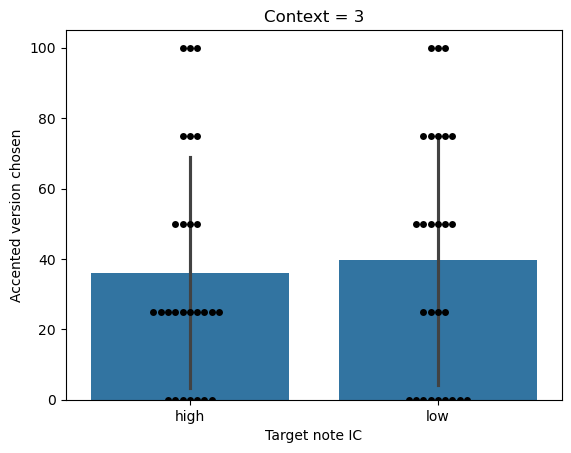

In [ ]:
#redoing same as above but plotting when accents were chosen (instead of score which inverses the correct answers for low and high IC)
fc_accents_3 = fc_3[fc_3['test_type']=='accent']


high_IC_accent_scores = []
low_IC_accent_scores = []

#screening for participants who answered the exposure questions correctly
for i in valid_participant_ids: 
    included_trials = fc_accents_3[fc_accents_3['subject'] == i]

    high_IC_trials = included_trials[included_trials['IC'] == 'high']
    low_IC_trials = included_trials[included_trials['IC'] == 'low']

    score_high_IC = calculate_score(high_IC_trials['accent_chosen'])
    score_low_IC = calculate_score(low_IC_trials['accent_chosen'])

    high_IC_accent_scores.append(score_high_IC)
    low_IC_accent_scores.append(score_low_IC)
    
        
fc_results_accent_high = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_accent_scores, 'IC': 'high'})
fc_results_accent_low = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': low_IC_accent_scores, 'IC': 'low'})

fc_accent_results_3 = pd.concat([fc_results_accent_high,fc_results_accent_low])

#ax = sns.violinplot(data = fc_accent_results_3, x  = 'IC' , y = 'score', ci = 'sd')

ax = sns.barplot(data = fc_accent_results_3, x  = 'IC' , y = 'score', ci = 'sd')
ax = sns.swarmplot(data = fc_accent_results_3, x  = 'IC' , y = 'score', color = 'black')
ax.set(xlabel='Target note IC', ylabel='Accented version chosen', title = 'Context = 3')

plt.savefig('supp_accent_bycontext_3.png', dpi = 300)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/4278128467.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data = fc_accent_results_5, x  = 'IC' , y = 'score', ci = 'sd')


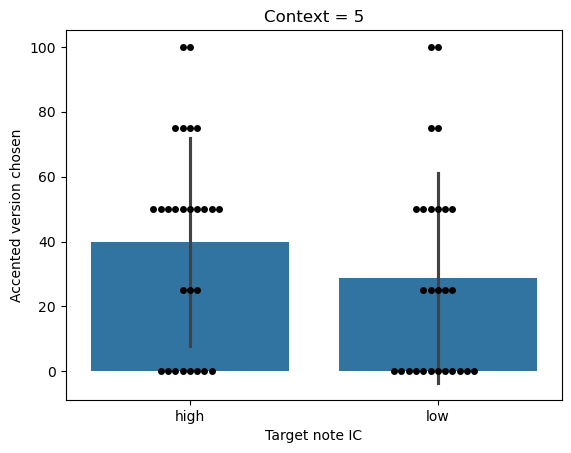

In [ ]:
#redoing same as above but plotting when accents were chosen (instead of score which inverses the correct answers for low and high IC)
fc_accents_5 = fc_5[fc_5['test_type']=='accent']


high_IC_accent_scores = []
low_IC_accent_scores = []

#screening for participants who answered the exposure questions correctly
for i in valid_participant_ids: 
    included_trials = fc_accents_5[fc_accents_5['subject'] == i]

    high_IC_trials = included_trials[included_trials['IC'] == 'high']
    low_IC_trials = included_trials[included_trials['IC'] == 'low']

    score_high_IC = calculate_score(high_IC_trials['accent_chosen'])
    score_low_IC = calculate_score(low_IC_trials['accent_chosen'])

    high_IC_accent_scores.append(score_high_IC)
    low_IC_accent_scores.append(score_low_IC)
    
        
fc_results_accent_high = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_accent_scores, 'IC': 'high'})
fc_results_accent_low = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': low_IC_accent_scores, 'IC': 'low'})

fc_accent_results_5 = pd.concat([fc_results_accent_high,fc_results_accent_low])


ax = sns.barplot(data = fc_accent_results_5, x  = 'IC' , y = 'score', ci = 'sd')
ax = sns.swarmplot(data = fc_accent_results_5, x  = 'IC' , y = 'score', color = 'black')
ax.set(xlabel='Target note IC', ylabel='Accented version chosen', title = 'Context = 5')

plt.savefig('supp_accent_bycontext_5.png', dpi = 300)

IC by context

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/3237202091.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data = fc_IC_results_3, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/3237202091.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = fc_IC_results_3, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/3237202091.py:30: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data = fc_IC_results_3, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])


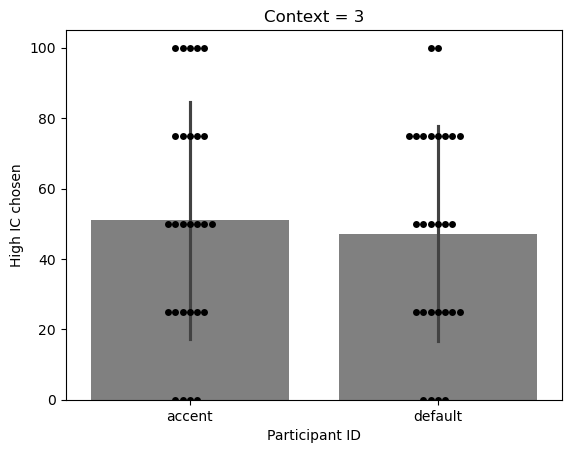

In [ ]:
fc_ICs_3_accent = fc_3[fc_3['test_type']=='IC_accent']


high_IC_chosen = []

#calculating results for when target note is accented
for i in valid_participant_ids: 
    included_trials = fc_ICs_3_accent[fc_ICs_3_accent['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen.append(score_IC)
        
fc_IC_results_3_accent = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen, 'accent_condition': 'accent'})

#calculating results for when target note is not accented
fc_ICs_3_default = fc_3[fc_3['test_type']=='IC_default']

high_IC_chosen = []

for i in valid_participant_ids: 
    included_trials = fc_ICs_3_default[fc_ICs_3_default['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen.append(score_IC)
        
fc_IC_results_3_default = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen, 'accent_condition': 'default'})


#appending the two dataframes together
fc_IC_results_3 = pd.concat([fc_IC_results_3_accent, fc_IC_results_3_default])

ax = sns.barplot(data = fc_IC_results_3, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
ax = sns.swarmplot(data = fc_IC_results_3, x = 'accent_condition', y = 'score', color = 'black')
ax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Context = 3')


plt.savefig('supp_IC_bycontext_3.png', dpi = 300)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1280719032.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(data = fc_IC_results_5, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1280719032.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = fc_IC_results_5, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1280719032.py:31: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data = fc_IC_results_5, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])


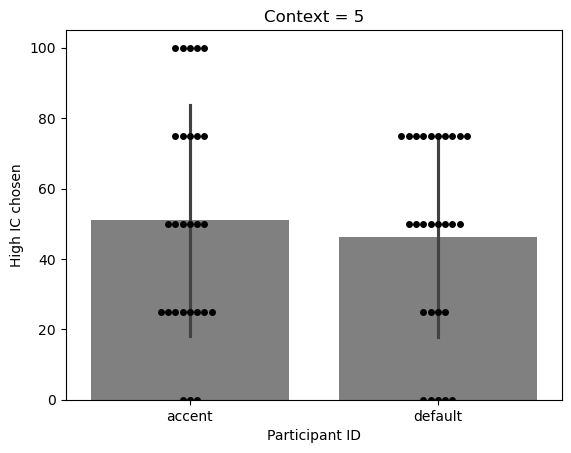

In [ ]:
fc_ICs_5_accent = fc_5[fc_5['test_type']=='IC_accent']


high_IC_chosen = []

#calculating results for when target note is accented
for i in valid_participant_ids: 
    included_trials = fc_ICs_5_accent[fc_ICs_5_accent['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen.append(score_IC)
        
fc_IC_results_5_accent = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen, 'accent_condition': 'accent'})

#calculating results for when target note is not accented
fc_ICs_5_default = fc_5[fc_5['test_type']=='IC_default']

high_IC_chosen = []

for i in valid_participant_ids: 
    included_trials = fc_ICs_5_default[fc_ICs_5_default['subject'] == i]
    score_IC = calculate_score(included_trials['high_IC_chosen'])
    high_IC_chosen.append(score_IC)
        
fc_IC_results_5_default = pd.DataFrame(data = {'valid_participant_ids': valid_participant_ids, 'score': high_IC_chosen, 'accent_condition': 'default'})


#appending the two dataframes together

fc_IC_results_5 = pd.concat([fc_IC_results_5_accent, fc_IC_results_5_default])

ax = sns.barplot(data = fc_IC_results_5, x  = 'accent_condition' , y = 'score', ci = 'sd', palette= ['grey'])
ax = sns.swarmplot(data = fc_IC_results_5, x = 'accent_condition', y = 'score', color = 'black')
ax.set(xlabel='Participant ID', ylabel='High IC chosen', title = 'Context = 5')

plt.savefig('supp_IC_bycontext_5.png', dpi = 300)

## PART 3: OLS Regression

Accent regression

In [ ]:
"""
takes a list of sequences and converts everything in the list to the expected durations
returns dataframe with file names and the list of durations
"""
def seq_to_df(seq_list, filename):

    filenames = []
    file_index = 1

    for item in seq_list:
        filenames.append(str(filename)+'_'+str(file_index)+'.mp3')
        
        file_index +=1
    df = pd.DataFrame(data = {'filename': filenames, 'sequence': seq_list})
    return df


In [ ]:
"""
takes the pkl lists in an experiment folder 
folder should be a string of the folder name
tonic should be 'tonic G4, tonic C4, etc' 
"""
def pkl_to_seq(folder, tonic):

    fc_IC_default_short_5 = pkl_to_list(folder+'/fc_IC_default_short_5.pkl')
    fc_IC_accent_short_5 = pkl_to_list(folder+'/fc_IC_accent_short_5.pkl')
    fc_IC_default_short_3 = pkl_to_list(folder+'/fc_IC_default_short_3.pkl')
    fc_IC_accent_short_3 = pkl_to_list(folder+'/fc_IC_accent_short_3.pkl')

    fc_accents_short_54 = pkl_to_list(folder+'/fc_accents_short_54.pkl')
    fc_accents_short_56 = pkl_to_list(folder+'/fc_accents_short_56.pkl')
    fc_accents_short_34 = pkl_to_list(folder+'/fc_accents_short_34.pkl')
    fc_accents_short_32 = pkl_to_list(folder+'/fc_accents_short_32.pkl')

    

    df_1 = seq_to_df(fc_accents_short_54, 'fc_accents_54')
    df_2 = seq_to_df(fc_accents_short_56, 'fc_accents_56')
    df_3 = seq_to_df(fc_accents_short_32, 'fc_accents_32')
    df_4 = seq_to_df(fc_accents_short_34, 'fc_accents_34')

    df_5 = seq_to_df(fc_IC_default_short_5, 'fc_IC_default_5')
    df_6 = seq_to_df(fc_IC_accent_short_5, 'fc_IC_accent_5')
    df_7 = seq_to_df(fc_IC_default_short_3, 'fc_IC_default_3')
    df_8 = seq_to_df(fc_IC_accent_short_3, 'fc_IC_accent_3')

    seq_df = pd.DataFrame(columns=['filename', 'sequence', 'condition'])
    seq_df= pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8], ignore_index= True)
    seq_df['condition'] = tonic

    return seq_df


In [ ]:
seq_df_G = pkl_to_seq('pkl files pilot 5', 'tonic G4')
seq_df_Bb = pkl_to_seq('pkl files pilot 5_1', 'tonic Bb4')
seq_df_C = pkl_to_seq('pkl files pilot 5_2', 'tonic C4')

seq_df_all = pd.concat([seq_df_G, seq_df_Bb, seq_df_C])

In [ ]:
seq_df_all

,filename,sequence,condition
0,fc_accents_54_1.mp3,"[1, 2, 6, 5, 4, 3, 1]",tonic G4
1,fc_accents_54_2.mp3,"[1, 2, 6, 5, 4, 3, 1]",tonic G4
2,fc_accents_54_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",tonic G4
3,fc_accents_54_4.mp3,"[1, 2, 6, 5, 4, 3, 1]",tonic G4
4,fc_accents_56_1.mp3,"[1, 2, 5, 6, 5, 3, 1]",tonic G4
...,...,...,...
27,fc_IC_default_3_4.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",tonic C4
28,fc_IC_accent_3_1.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",tonic C4
29,fc_IC_accent_3_2.mp3,"[1, 2, 6, 3, 2, 3, 1]",tonic C4
30,fc_IC_accent_3_3.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",tonic C4


In [ ]:
fc.rename(columns={'stimulus': 'filename'}, inplace=True)
fc = pd.merge(fc, seq_df_all, on=['filename', 'condition'], how='left')

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/2499840665.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc.rename(columns={'stimulus': 'filename'}, inplace=True)


In [ ]:
#adding column for IC
def truncate_stimulus_IC(x):
    if x[-8:-6] == '54' or x[-8:-6] == '34':
        return 'low'
    elif x[-8:-6] == '32' or x[-8:-6] == '56':
        return 'high'
    else:
        return 'NA'
fc['IC'] = fc['filename'].map(truncate_stimulus_IC)


#adding target positions
def target_finder_all(melody):
    for i in range(len(melody)):
        if melody[i] == 4 and melody [i-1] == 3:
            return i
        elif melody[i] == 4 and melody [i-1] == 5:
            return i
        elif melody[i] == 2 and melody [i-1] == 3:
            return i
        elif melody[i] == 6 and melody [i-1] == 5:
            return i

fc['target_pos'] = fc['sequence'].map(target_finder_all)

#adding movement before target note
#1 means the movement is ascending
def add_before_asc(melody):
   tar_pos = target_finder_all(melody)
   if melody[tar_pos] < melody[tar_pos -1]:
       return 0
   elif melody[tar_pos] > melody[tar_pos -1]:
        return 1
   else:
       return 'NA'
fc['before_asc'] = fc['sequence'].map(add_before_asc)

#adding movement after target note
def add_after_asc(melody):
   tar_pos = target_finder_all(melody)
   if melody[tar_pos] < melody[tar_pos + 1]:
       return 1
   elif melody[tar_pos] > melody[tar_pos + 1]:
        return 0
   else:
       return 'NA'
fc['after_asc'] = fc['sequence'].map(add_after_asc)

#changing accent and IC column to binary values
def binary_map(x):
    if x == False or x == 'low':
        return 0
    elif x == True or x == 'high':
        return 1
    
fc['accent_chosen'] = fc['accent_chosen'].map(binary_map)
fc['IC'] = fc['IC'].map(binary_map) #HIGH IC is 1

#melodic contours
fc['invU'] = (fc['before_asc'] == 1) & (fc['after_asc'] == 0)
fc['invU'] = fc['invU'].astype(int)

fc['U'] = (fc['before_asc'] == 0) & (fc['after_asc'] == 1)
fc['U'] = fc['U'].astype(int)

fc['asc'] = (fc['before_asc'] == 1) & (fc['after_asc'] == 1)
fc['asc'] = fc['asc'].astype(int)

fc['des'] = (fc['before_asc'] == 0) & (fc['after_asc'] == 0)
fc['des'] = fc['des'].astype(int)

#all melodic contours as one factor
def add_contour(melody):
    tar_pos = target_finder_all(melody)
    if melody[tar_pos] < melody[tar_pos - 1] and melody[tar_pos] > melody[tar_pos +1]:
        return 'des'
    elif melody[tar_pos] > melody[tar_pos - 1] and melody[tar_pos] > melody[tar_pos +1]:
        return 'inv-U'
    elif melody[tar_pos] < melody[tar_pos - 1] and melody[tar_pos] < melody[tar_pos + 1]:
        return 'U'
    elif melody[tar_pos] > melody[tar_pos -1] and melody[tar_pos] < melody[tar_pos + 1]:
        return 'asc'
    else:
        return 'NA'

fc['contour'] = fc['sequence'].map(add_contour)

#metrical position of target
fc['target_metric_4'] = fc['target_pos']%4+1
fc['target_metric_2'] = fc['target_pos']%2+1



In [ ]:
#making dataframe with just the columns that are relevant for regression
reg_accent_columns = ['subject', 'condition', 'filename', 'sequence', 'accent_chosen', 'IC', 'target_pos', 'invU', 'U', 'asc', 'des', 'target_metric_2', 'target_metric_4', 'contour']

fc_accent_regression = fc[reg_accent_columns]
fc_accent_regression = fc_accent_regression.dropna()

#fc_accent_regression

In [ ]:
fc_accent_regression[['sequence', 'invU', 'U', 'asc', 'des', 'IC', 'contour']]

,sequence,invU,U,asc,des,IC,contour
1,"[1, 2, 6, 3, 2, 5, 3, 1]",0,1,0,0,1.0,U
2,"[1, 2, 6, 5, 4, 3, 1]",0,0,0,1,0.0,des
4,"[1, 2, 6, 3, 2, 3, 1]",0,1,0,0,1.0,U
6,"[1, 2, 6, 5, 6, 5, 3, 1]",1,0,0,0,1.0,inv-U
7,"[1, 2, 6, 5, 6, 3, 1]",1,0,0,0,1.0,inv-U
...,...,...,...,...,...,...,...
1043,"[1, 2, 5, 4, 3, 1]",0,0,0,1,0.0,des
1045,"[1, 2, 3, 4, 5, 3, 1]",0,0,1,0,0.0,asc
1047,"[1, 2, 6, 5, 6, 5, 3, 1]",1,0,0,0,1.0,inv-U
1051,"[1, 2, 3, 6, 3, 4, 3, 1]",1,0,0,0,0.0,inv-U


Participants

In [ ]:
musicians = [x for x in musicians_57+musicians_710+musicians_10 if x not in failed_participants]
#musicians = [x for x in musicians_710+musicians_10 if x not in failed_participants]

nonmusicians = [x for x in participant_ids if x not in musicians and x not in failed_participants]

In [ ]:
#finding coefficients

def coefs(x):  
    coefs_df = pd.DataFrame()
    for i in x:
        fc_accent_regression_subject = fc_accent_regression.query(f"subject == '{i}'")
        # y, X = dmatrices('accent_chosen ~ C(IC) + C(U) + C(invU) + C(asc) + C(des)', data=fc_accent_regression_subject, return_type='dataframe')
        y, X = dmatrices("accent_chosen ~ C(IC) + C(contour, Treatment('des'))", data=fc_accent_regression_subject, return_type='dataframe')

        mod = sm.OLS(y, X) 
        res = mod.fit() 

        #print(res.summary())
        coefs = res.params
        coefs_df = coefs_df.append([coefs])

    return coefs_df


In [ ]:
coefs_all = coefs(valid_participant_ids)
coefs_musicians = coefs(musicians)
coefs_nonmusicians = coefs(nonmusicians)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/2670194618.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/2670194618.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/2670194618.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/2670194618.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.

In [ ]:
#coefficient summary statistics


def coefs_summary(df): #takes dataframae
    summary = pd.DataFrame({
    'means': df.mean(),
    'sems': df.sem()
    })
    summary = summary.reset_index() 
    return summary


summary_musicians = coefs_summary(coefs_musicians)
summary_nonmusicians = coefs_summary(coefs_nonmusicians)
summary_all = coefs_summary(coefs_all)

In [ ]:
#preparing data for split violin plot
coefs_musicians_plot = coefs_musicians.melt(value_name= 'coefficient')
coefs_nonmusicians_plot = coefs_nonmusicians.melt(value_name = 'coefficient')
coefs_musicians_plot['music_level'] = 'musician'
coefs_nonmusicians_plot['music_level'] = 'nonmusician'

#attention becasue the same variable is being used for another (now probably useless) figure below
coefs_all_plot = pd.concat([coefs_musicians_plot, coefs_nonmusicians_plot])


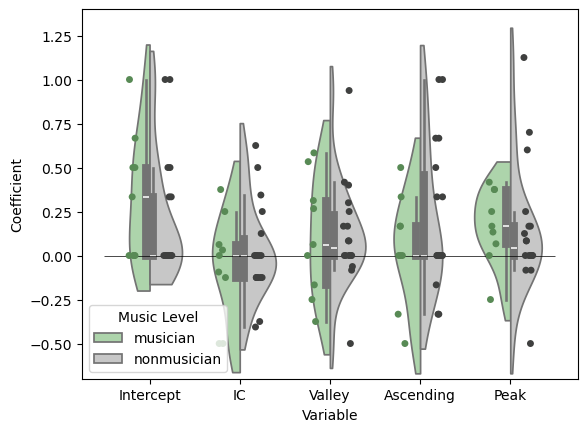

In [ ]:
#split violin plot
ax = sns.violinplot(data=coefs_all_plot, x="variable", y="coefficient", hue="music_level",
               split=True, palette = {'musician': '#a7dba4', 'nonmusician': '#c7c7c7'}, cut = 0.85, inner = 'box')
               #inner="quart", linewidth=1)
ax.legend(title="Music Level", loc = 'lower left')

sns.stripplot(data=coefs_all_plot, x="variable", y="coefficient", hue="music_level", 
              dodge=True, jitter=True, 
               palette = {'musician': '#588a55', 'nonmusician': '#3f403f'}, legend = False)
#sns.despine(left=True)

plt.hlines(0,-0.5,4.5, color = 'black', linewidth = 0.5)
plt.ylim(-0.7, 1.4)
plt.xticks([0, 1, 2, 3, 4], ['Intercept', 'IC', 'Valley', 'Ascending', 'Peak'])
plt.ylabel('Coefficient')
plt.xlabel('Variable')

plt.savefig('./figures for paper/regression_accent.png', dpi = 500)

In [ ]:
#stats for regression above
print('Musicians')
regression_ttest_intercept_musicians = stats.ttest_1samp(coefs_musicians['Intercept'], popmean = 0)
regression_ttest_invU_musicians = stats.ttest_1samp(coefs_musicians["C(contour, Treatment('des'))[T.inv-U]"], popmean = 0)
regression_ttest_U_musicians = stats.ttest_1samp(coefs_musicians["C(contour, Treatment('des'))[T.U]"], popmean = 0)

print('intercept', regression_ttest_intercept_musicians)
print('inv-U', regression_ttest_invU_musicians)
print('U', regression_ttest_U_musicians)

print('\nNonmusicians')
regression_ttest_intercept_nonmusicians = stats.ttest_1samp(coefs_nonmusicians['Intercept'], popmean = 0)
regression_ttest_invU_nonmusicians = stats.ttest_1samp(coefs_nonmusicians["C(contour, Treatment('des'))[T.inv-U]"], popmean = 0)
regression_ttest_U_nonmusicians = stats.ttest_1samp(coefs_nonmusicians["C(contour, Treatment('des'))[T.U]"], popmean = 0)

print('intercept', regression_ttest_intercept_nonmusicians)
print('inv-U', regression_ttest_invU_nonmusicians)
print('U', regression_ttest_U_nonmusicians)

Musicians
intercept TtestResult(statistic=2.752988806446742, pvalue=0.024943468226206977, df=8)
inv-U TtestResult(statistic=2.381041768402239, pvalue=0.044473305040513784, df=8)
U TtestResult(statistic=0.947880807854563, pvalue=0.37093934414145974, df=8)

Nonmusicians
intercept TtestResult(statistic=2.5353747257555437, pvalue=0.021342087987857552, df=17)
inv-U TtestResult(statistic=1.7486419591456333, pvalue=0.09838535971543859, df=17)
U TtestResult(statistic=1.7500563985497697, pvalue=0.09813465642709422, df=17)


IC regression

In [ ]:
#making dataframe with just the columns that are relevant for regression
reg_IC_columns = ['subject', 'condition', 'filename', 'sequence', 'IC', 'high_IC_chosen', 'target_pos', 'target_metric_2', 'target_metric_4']

fc_IC_regression = fc[reg_IC_columns]
fc_IC_regression = fc_IC_regression[fc_IC_regression['IC'].isnull()]

def truncate_accent_condition(x):
    if x[6] == 'a':
        return 1
    elif x[6] == 'd':
        return 0
    else:
        return 'NA'
fc_IC_regression['accent'] = fc_IC_regression['filename'].map(truncate_accent_condition)

fc_IC_regression['high_IC_chosen'] = fc_IC_regression['high_IC_chosen'].map(binary_map)

fc_IC_regression

,subject,condition,filename,sequence,IC,high_IC_chosen,target_pos,target_metric_2,target_metric_4,accent
0,m7mhvm,tonic G4,fc_IC_accent_5_1.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
3,m7mhvm,tonic G4,fc_IC_accent_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
5,m7mhvm,tonic G4,fc_IC_default_3_4.mp3,"[1, 2, 6, 3, 2, 3, 1]",NaN,0,4,1,1,0
8,m7mhvm,tonic G4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
9,m7mhvm,tonic G4,fc_IC_default_5_2.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,0,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1049,y59mja,tonic C4,fc_IC_default_5_1.mp3,"[1, 2, 6, 5, 4, 3, 1]",NaN,0,4,1,1,0
1050,y59mja,tonic C4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
1053,y59mja,tonic C4,fc_IC_default_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,0
1054,y59mja,tonic C4,fc_IC_default_3_2.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",NaN,0,4,1,1,0


In [ ]:
def coefs_IC(x):  
    coefs_df = pd.DataFrame()
    for i in x:
        fc_IC_regression_subject = fc_IC_regression.query(f"subject == '{i}'")
        #y, X = dmatrices('high_IC_chosen ~  accent + target_metric_2', data=fc_IC_regression_subject, return_type='dataframe')
        y, X = dmatrices('high_IC_chosen ~  C(accent)', data=fc_IC_regression_subject, return_type='dataframe')
        mod = sm.OLS(y, X) 
        res = mod.fit() 

        #print(res.summary())
        coefs = res.params
        coefs_df = coefs_df.append([coefs])

    return coefs_df

In [ ]:
coefs_IC_all = coefs_IC(valid_participant_ids)
coefs_IC_musicians = coefs_IC(musicians)
coefs_IC_nonmusicians = coefs_IC(nonmusicians)

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1114386903.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1114386903.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1114386903.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.append([coefs])
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_49397/1114386903.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefs_df = coefs_df.

In [ ]:
#coefficient summary statistics
summary_IC_musicians = coefs_summary(coefs_IC_musicians)
summary_IC_nonmusicians = coefs_summary(coefs_IC_nonmusicians)

In [ ]:
#preparing data for split violin plot
coefs_IC_musicians_plot = coefs_IC_musicians.melt(value_name= 'coefficient')
coefs_IC_nonmusicians_plot = coefs_IC_nonmusicians.melt(value_name = 'coefficient')
coefs_IC_musicians_plot['music_level'] = 'musician'
coefs_IC_nonmusicians_plot['music_level'] = 'nonmusician'

coefs_IC_all_plot = pd.concat([coefs_IC_musicians_plot, coefs_IC_nonmusicians_plot])
#coefs_IC_all_plot

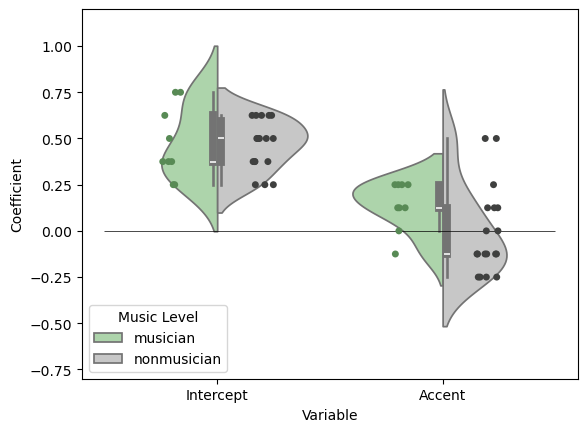

In [ ]:
#split violin plot
ax = sns.violinplot(data=coefs_IC_all_plot, x="variable", y="coefficient", hue="music_level", 
               split=True, palette = {'musician': '#a7dba4', 'nonmusician': '#c7c7c7'})
               #inner="quart", linewidth=1,
            #   palette={"Yes": "b", "No": ".85"})
ax.legend(title="Music Level", loc = 'lower left')

sns.stripplot(data=coefs_IC_all_plot, x="variable", y="coefficient", hue="music_level", 
              dodge=True, jitter=True, 
               palette = {'musician': '#588a55', 'nonmusician': '#3f403f'}, legend = False)
#sns.despine(left=True)

plt.hlines(0,-0.5,1.5, color = 'black', linewidth = 0.5)
plt.ylim(-0.8, 1.2)
plt.xticks([0, 1], ['Intercept', 'Accent'])
plt.ylabel('Coefficient')
plt.xlabel('Variable')
plt.savefig('./figures for paper/regression_IC.png', dpi = 500)

In [ ]:
print('Musicians')
regression_IC_ttest_intercept_musicians = stats.ttest_1samp(coefs_IC_musicians['Intercept'], popmean = 0)
regression_IC_ttest_accent_musicians = stats.ttest_1samp(coefs_IC_musicians['C(accent)[T.1]'], popmean = 0)

print('Intercept', regression_IC_ttest_intercept_musicians)
print('Accent', regression_IC_ttest_accent_musicians)

print('\nNonmusicians')
regression_IC_ttest_intercept_nonmusicians = stats.ttest_1samp(coefs_IC_nonmusicians['Intercept'], popmean = 0)
regression_IC_ttest_accent_nonmusicians = stats.ttest_1samp(coefs_IC_nonmusicians['C(accent)[T.1]'], popmean = 0)

print('Intercept', regression_IC_ttest_intercept_nonmusicians)
print('Accent', regression_IC_ttest_accent_nonmusicians)

Musicians
Intercept TtestResult(statistic=7.248824356090755, pvalue=8.815451372112449e-05, df=8)
Accent TtestResult(statistic=3.1622776601683777, pvalue=0.013349063426018748, df=8)

Nonmusicians
Intercept TtestResult(statistic=14.70320155535308, pvalue=4.2497487837537274e-11, df=17)
Accent TtestResult(statistic=-0.12448618188538396, pvalue=0.9023904891408141, df=17)


In [ ]:
print('Musicians')
regression_IC_ttest_accent_musicians = stats.ttest_ind(coefs_IC_musicians['C(accent)[T.1]'], coefs_IC_nonmusicians['C(accent)[T.1]'])

print(regression_IC_ttest_accent_musicians)


Musicians
TtestResult(statistic=1.7098618906111098, pvalue=0.09967670946469437, df=25.0)


In [ ]:
fc_IC_regression

,subject,condition,filename,sequence,IC,high_IC_chosen,target_pos,target_metric_2,target_metric_4,accent
0,m7mhvm,tonic G4,fc_IC_accent_5_1.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
3,m7mhvm,tonic G4,fc_IC_accent_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
5,m7mhvm,tonic G4,fc_IC_default_3_4.mp3,"[1, 2, 6, 3, 2, 3, 1]",NaN,0,4,1,1,0
8,m7mhvm,tonic G4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
9,m7mhvm,tonic G4,fc_IC_default_5_2.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,0,4,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1049,y59mja,tonic C4,fc_IC_default_5_1.mp3,"[1, 2, 6, 5, 4, 3, 1]",NaN,0,4,1,1,0
1050,y59mja,tonic C4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1
1053,y59mja,tonic C4,fc_IC_default_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,0
1054,y59mja,tonic C4,fc_IC_default_3_2.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",NaN,0,4,1,1,0


## Additional analyses

Relative target position vs accent choice

In [ ]:
def rel_target_positions(df):
    lengths = [len(x) for x in df['sequence']]
    target_pos = list(df['target_pos'])
    rel_target_positions = [x / y for x, y in zip(target_pos, lengths)]

    return rel_target_positions


IC_target_positions = rel_target_positions(fc_IC_regression)
accent_target_positions = rel_target_positions(fc_accent_regression)

Text(0.5, 1.0, 'IC forced choice')

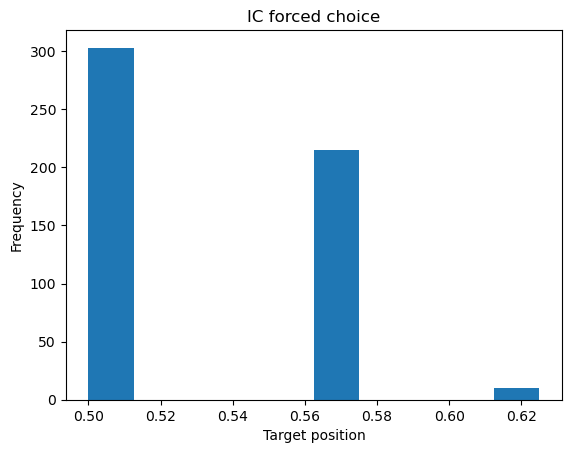

In [ ]:
plt.hist(IC_target_positions)
plt.xlabel('Target position')
plt.ylabel('Frequency')
plt.title('IC forced choice')

Text(0.5, 1.0, 'Accent forced choice')

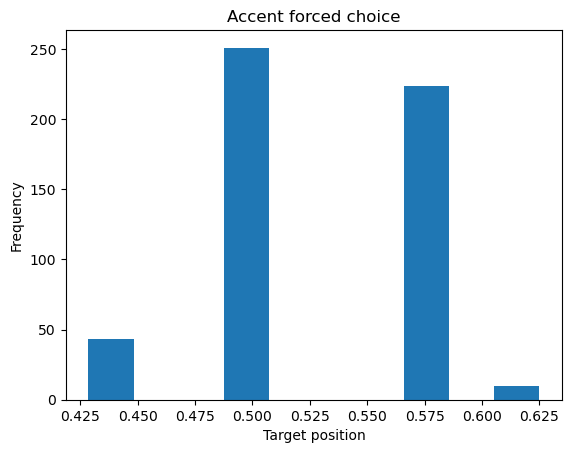

In [ ]:

plt.hist(accent_target_positions)
plt.xlabel('Target position')
plt.ylabel('Frequency')
plt.title('Accent forced choice')

## Linear mixed models

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
md = smf.mixedlm("Weight ~ Time + Start + Litter", data, groups=data['Pig'])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3668   
Min. group size:  11      Log-Likelihood:     -2367.4200
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept -21.752    3.247  -6.700 0.000 -28.115 -15.388
Time        6.942    0.033 207.943 0.000   6.877   7.008
Start       1.456    0.120  12.104 0.000   1.221   1.692
Litter      0.008    0.059   0.131 0.896  -0.107   0.123
Group Var  12.651    0.716                              



In [ ]:
def sort_musicians(x):
    if x in musicians:
        return 1
    else:
        return 0

fc_IC_regression['musician'] = fc_IC_regression['subject'].apply(lambda x: sort_musicians(x))

In [ ]:
fc_IC_regression['musician'].value_counts()

0    384
1    144
Name: musician, dtype: int64

In [ ]:
# Convert variables to categorical
#fc_IC_regression['high_IC_chosen'] = fc_IC_regression['high_IC_chosen'].astype('category')
#fc_IC_regression['accent'] = fc_IC_regression['accent'].astype('category')


In [ ]:
fc_IC_regression

,subject,condition,filename,sequence,IC,high_IC_chosen,target_pos,target_metric_2,target_metric_4,accent,musician
0,m7mhvm,tonic G4,fc_IC_accent_5_1.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1,0
3,m7mhvm,tonic G4,fc_IC_accent_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1,0
5,m7mhvm,tonic G4,fc_IC_default_3_4.mp3,"[1, 2, 6, 3, 2, 3, 1]",NaN,0,4,1,1,0,0
8,m7mhvm,tonic G4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1,0
9,m7mhvm,tonic G4,fc_IC_default_5_2.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,0,4,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1049,y59mja,tonic C4,fc_IC_default_5_1.mp3,"[1, 2, 6, 5, 4, 3, 1]",NaN,0,4,1,1,0,0
1050,y59mja,tonic C4,fc_IC_accent_5_3.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,1,0
1053,y59mja,tonic C4,fc_IC_default_5_4.mp3,"[1, 2, 6, 5, 4, 5, 3, 1]",NaN,1,4,1,1,0,0
1054,y59mja,tonic C4,fc_IC_default_3_2.mp3,"[1, 2, 6, 3, 2, 5, 3, 1]",NaN,0,4,1,1,0,0


In [ ]:
md_IC = smf.mixedlm("high_IC_chosen ~ C(accent)", fc_IC_regression, groups=fc_IC_regression['subject'])
mdf_IC = md_IC.fit(method=["lbfgs"])
print(mdf_IC.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: high_IC_chosen
No. Observations: 528     Method:             REML          
No. Groups:       33      Scale:              0.2406        
Min. group size:  16      Log-Likelihood:     -384.7842     
Max. group size:  16      Converged:          Yes           
Mean group size:  16.0                                      
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.447    0.034 12.996 0.000  0.380  0.514
C(accent)[T.1]     0.072    0.043  1.686 0.092 -0.012  0.156
Group Var          0.009    0.013                           



/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
fc_accent_regression['musician'] = fc_accent_regression['subject'].apply(lambda x: sort_musicians(x))

In [ ]:
md_accent = smf.mixedlm("accent_chosen ~ C(IC)  + C(asc) + C(invU) ", fc_accent_regression, groups=fc_accent_regression['subject'])
mdf_accent = md_accent.fit(method=["lbfgs"])
print(mdf_accent.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: accent_chosen
No. Observations: 528     Method:             REML         
No. Groups:       33      Scale:              0.1616       
Min. group size:  16      Log-Likelihood:     -309.4358    
Max. group size:  16      Converged:          Yes          
Mean group size:  16.0                                     
------------------------------------------------------------
               Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------
Intercept      0.295     0.057  5.220  0.000   0.184   0.406
C(IC)[T.1.0]   0.068     0.041  1.685  0.092  -0.011   0.148
C(asc)[T.1]    0.121     0.053  2.261  0.024   0.016   0.225
C(invU)[T.1]   0.053     0.041  1.303  0.193  -0.027   0.132
Group Var      0.072     0.053                              



/Users/cindyzhang/anaconda3/envs/musicIC2/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
